In [1]:
pwd

'/root/gcubme4/Workspace/SH_Lim/Lateral'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import tensorflow as tf
import keras 
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from keras import backend as K
from keras.utils import plot_model
from keras.models import load_model
from keras.utils import multi_gpu_model
import cv2
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import Model
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import random
import pandas as pd
from keras import losses
from skimage.io import imsave, imread

Using TensorFlow backend.


In [3]:
img_dir = sorted(glob.glob('./image/*.jpg'))

print(img_dir[0])

X = []

for i in (img_dir):
    imager = imread(i)
    X.append(np.array(imager))
    
X = np.array(X)
X = np.expand_dims(X, axis=3)

print(X.shape)

./image/I0000000002_1.jpg
(1646, 512, 512, 1)


In [4]:
img = X / 255.0

label = pd.read_csv('./each_bone_CR.csv')
print(img.shape)

Y = []

Y_max = 0

for i in range(len(X)):
    Y.append(label.loc[i].CR)
    if Y_max < label.loc[i].CR:
        Y_max = label.loc[i].CR
    
Y = np.array(Y)
print(Y.shape, '\n')

img = img.astype(np.float32)
Y = Y.astype(np.float32)

print(img.shape, Y.shape)
print(img.dtype, Y.dtype, '\n')

print(Y_max, '\n')
print(img.max(), Y.max())

(1646, 512, 512, 1)
(1646,) 

(1646, 512, 512, 1) (1646,)
float32 float32 

59.0609 

1.0 59.0609


In [5]:
#  for i in range(len(img_dir)):
#     print((img_dir[i].split('/')[2])[:-4] + '      '  + label.loc[i].file_name)
#     assert (img_dir[i].split('/')[2])[:-4] == label.loc[i].file_name

In [6]:
# for i in range(0, 20):
#     plt.imshow(img[i,:,:,0], cmap='gray')
#     plt.show()

In [7]:
train_x = img[:1000]
train_y = Y[:1000]

val_x = img[1000:1323]
val_y = Y[1000:1323]

# # with out validation set
# train_x = np.concatenate((train_x, val_x), axis=0)
# train_y = np.concatenate((train_y, val_y))

test_x = img[1323:]
test_y = Y[1323:]

print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)
print(test_x.shape, test_y.shape)

(1000, 512, 512, 1) (1000,)
(323, 512, 512, 1) (323,)
(323, 512, 512, 1) (323,)


In [8]:
help(AveragePooling2D)

Help on class AveragePooling2D in module keras.layers.pooling:

class AveragePooling2D(_Pooling2D)
 |  Average pooling operation for spatial data.
 |  
 |  # Arguments
 |      pool_size: integer or tuple of 2 integers,
 |          factors by which to downscale (vertical, horizontal).
 |          (2, 2) will halve the input in both spatial dimension.
 |          If only one integer is specified, the same window length
 |          will be used for both dimensions.
 |      strides: Integer, tuple of 2 integers, or None.
 |          Strides values.
 |          If None, it will default to `pool_size`.
 |      padding: One of `"valid"` or `"same"` (case-insensitive).
 |      data_format: A string,
 |          one of `channels_last` (default) or `channels_first`.
 |          The ordering of the dimensions in the inputs.
 |          `channels_last` corresponds to inputs with shape
 |          `(batch, height, width, channels)` while `channels_first`
 |          corresponds to inputs with shape

In [9]:
help(Conv2D)

Help on class Conv2D in module keras.layers.convolutional:

class Conv2D(_Conv)
 |  2D convolution layer (e.g. spatial convolution over images).
 |  
 |  This layer creates a convolution kernel that is convolved
 |  with the layer input to produce a tensor of
 |  outputs. If `use_bias` is True,
 |  a bias vector is created and added to the outputs. Finally, if
 |  `activation` is not `None`, it is applied to the outputs as well.
 |  
 |  When using this layer as the first layer in a model,
 |  provide the keyword argument `input_shape`
 |  (tuple of integers, does not include the batch axis),
 |  e.g. `input_shape=(128, 128, 3)` for 128x128 RGB pictures
 |  in `data_format="channels_last"`.
 |  
 |  # Arguments
 |      filters: Integer, the dimensionality of the output space
 |          (i.e. the number of output filters in the convolution).
 |      kernel_size: An integer or tuple/list of 2 integers, specifying the
 |          height and width of the 2D convolution window.
 |         

In [10]:
help(concatenate)

Help on function concatenate in module keras.layers.merge:

concatenate(inputs, axis=-1, **kwargs)
    Functional interface to the `Concatenate` layer.
    
    # Arguments
        inputs: A list of input tensors (at least 2).
        axis: Concatenation axis.
        **kwargs: Standard layer keyword arguments.
    
    # Returns
        A tensor, the concatenation of the inputs alongside axis `axis`.



In [14]:
# 많은 파라미터가 생기기 때문에 가장 중요한 피쳐맵을 뽑는 아랫단에만 넣는다는 개념

def growth_rate(l, filters, k=4):
    gr = k * (l - 1) + filters
    return gr

def dense_block(inputs, gr):

    
    x = BatchNormalization()(inputs)
    x = Activation(activation='relu')(x)
    x = Conv2D(gr*4, 1, activation=None, padding='same', kernel_initializer='he_normal')(x)
    

    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    x = Conv2D(gr, 3, activation=None, padding='same', kernel_initializer='he_normal')(x)
    
    x = concatenate([inputs,x], axis=3)
    
    dense_out = Activation(activation='relu')(x)
    
    
    return dense_out
    
def transition_block(dense_out, gr):
    
    t = BatchNormalization()(dense_out)
    t = Activation(activation='relu')(t)
    t = Conv2D(gr, 1, activation=None, padding='same', kernel_initializer='he_normal')(t)

    
    avg_pool = AveragePooling2D(pool_size=(2,2), strides=2)(t)
    
    t = Activation(activation='relu')(avg_pool)
  
    return t
  

def Dense_regression_model(input_img, base = 32, scale = 2):

    conv1 = BatchNormalization()(input_img)
    conv1 = Activation(activation='relu')(conv1)
    conv1 = Conv2D(base, 7, strides= 2, activation=None, padding='same', kernel_initializer='he_normal')(conv1)
    
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation(activation='relu')(conv1)
    conv1 = Conv2D(base, 7, strides=2, activation=None, padding='same', kernel_initializer='he_normal')(conv1)
    
    conv1 = MaxPooling2D(pool_size=(3, 3), strides = 2)(conv1)
    
    growth = growth_rate(1, base)
    
    for i in range(6):

        conv1 = dense_block(conv1, growth)
    
    pool1 = transition_block(conv1,growth)
    
    growth = growth_rate(2, base)
    conv2 = dense_block(pool1, growth)
    
    for i in range(11):

        conv2 = dense_block(conv2, growth)

    pool2 = transition_block(conv2,growth)
    
    
    growth = growth_rate(3, base)
    conv3 = dense_block(pool2, growth)
    
    for i in range(23):

        conv3 = dense_block(conv3, growth)
    
    pool3 = transition_block(conv3,growth)
            
        
    growth = growth_rate(4, base)
    conv4 = dense_block(pool3, growth) 
    
    for i in range(15):

        conv4 = dense_block(conv4, growth)
        
    pool4 = transition_block(conv4,growth)            


    out= GlobalAveragePooling2D()(pool4)
    
    out = Dense(1, activation="linear")(out)
    model = Model(inputs=input_img, outputs=out)
    
    return model


In [12]:
help(GlobalAveragePooling2D)

Help on class GlobalAveragePooling2D in module keras.layers.pooling:

class GlobalAveragePooling2D(_GlobalPooling2D)
 |  Global average pooling operation for spatial data.
 |  
 |  # Arguments
 |      data_format: A string,
 |          one of `channels_last` (default) or `channels_first`.
 |          The ordering of the dimensions in the inputs.
 |          `channels_last` corresponds to inputs with shape
 |          `(batch, height, width, channels)` while `channels_first`
 |          corresponds to inputs with shape
 |          `(batch, channels, height, width)`.
 |          It defaults to the `image_data_format` value found in your
 |          Keras config file at `~/.keras/keras.json`.
 |          If you never set it, then it will be "channels_last".
 |  
 |  # Input shape
 |      - If `data_format='channels_last'`:
 |          4D tensor with shape:
 |          `(batch_size, rows, cols, channels)`
 |      - If `data_format='channels_first'`:
 |          4D tensor with shape:
 |    

In [15]:
from keras.models import Sequential

input_img = Input(shape=(512,512,1))
model = Dense_regression_model(input_img, base = 16, scale = 2)
model.summary()

W0730 18:41:02.168930 137315823798416 module_wrapper.py:139] From /opt/anaconda/envs/powerai_162/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0730 18:41:03.249565 137315823798416 module_wrapper.py:139] From /opt/anaconda/envs/powerai_162/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4271: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0730 18:41:11.301610 137315823798416 module_wrapper.py:139] From /opt/anaconda/envs/powerai_162/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 512, 512, 1)  4           input_2[0][0]                    
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 512, 512, 1)  0           batch_normalization_3[0][0]      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 800         activation_3[0][0]               
____________________________________________________________________________________________

In [16]:
# model = multi_gpu_model(model, gpus=4)

batch_size = 4
monitor = 'val_loss'

model.compile(optimizer=Adam(lr=0.01), loss='mae', metrics=['mse'])

checkpointer = ModelCheckpoint(filepath='./Lateral_dense_ori_.h5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor=monitor, factor=0.2,
                              patience=10, min_lr=0.000001,verbose=1)
earlystopper = EarlyStopping(patience=50, verbose=1, monitor=monitor)

W0730 18:41:11.575897 137315823798416 module_wrapper.py:139] From /opt/anaconda/envs/powerai_162/lib/python3.6/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [17]:
# train, test
# results = model.fit(train_x, train_y, epochs=500,callbacks = [reduce_lr, earlystopper, checkpointer])
# train, val, test
results = model.fit(train_x, train_y, validation_data = (val_x, val_y), epochs=500, callbacks = [reduce_lr, earlystopper, checkpointer])

W0730 18:41:15.794559 137315823798416 module_wrapper.py:139] From /opt/anaconda/envs/powerai_162/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0730 18:41:19.903851 137315823798416 module_wrapper.py:139] From /opt/anaconda/envs/powerai_162/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 1000 samples, validate on 323 samples
Epoch 1/500
1000/1000 [==============================] - 48s 48ms/step - loss: 8.5841 - mean_squared_error: 134.2749 - val_loss: 2085.1164 - val_mean_squared_error: 4688789.7276

Epoch 00001: val_loss improved from inf to 2085.11638, saving model to ./Lateral_dense_ori_.h5
Epoch 2/500
1000/1000 [==============================] - 10s 10ms/step - loss: 8.0311 - mean_squared_error: 118.6355 - val_loss: 190.9113 - val_mean_squared_error: 44114.7085

Epoch 00002: val_loss improved from 2085.11638 to 190.91131, saving model to ./Lateral_dense_ori_.h5
Epoch 3/500
1000/1000 [==============================] - 10s 10ms/step - loss: 7.8122 - mean_squared_error: 112.9818 - val_loss: 100.8522 - val_mean_squared_error: 11432.4476

Epoch 00003: val_loss improved from 190.91131 to 100.85220, saving model to ./Lateral_dense_ori_.h5
Epoch 4/500
1000/1000 [==============================] - 10s 10ms/step - loss: 7.7823 - mean_squared_error: 113.4364 - val_los

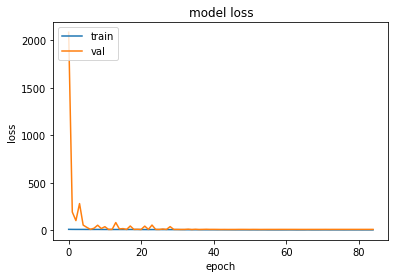

In [18]:
fig = plt.figure()
plt.axes(facecolor='white')
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1000/1000 [==============================] - 4s 4ms/step


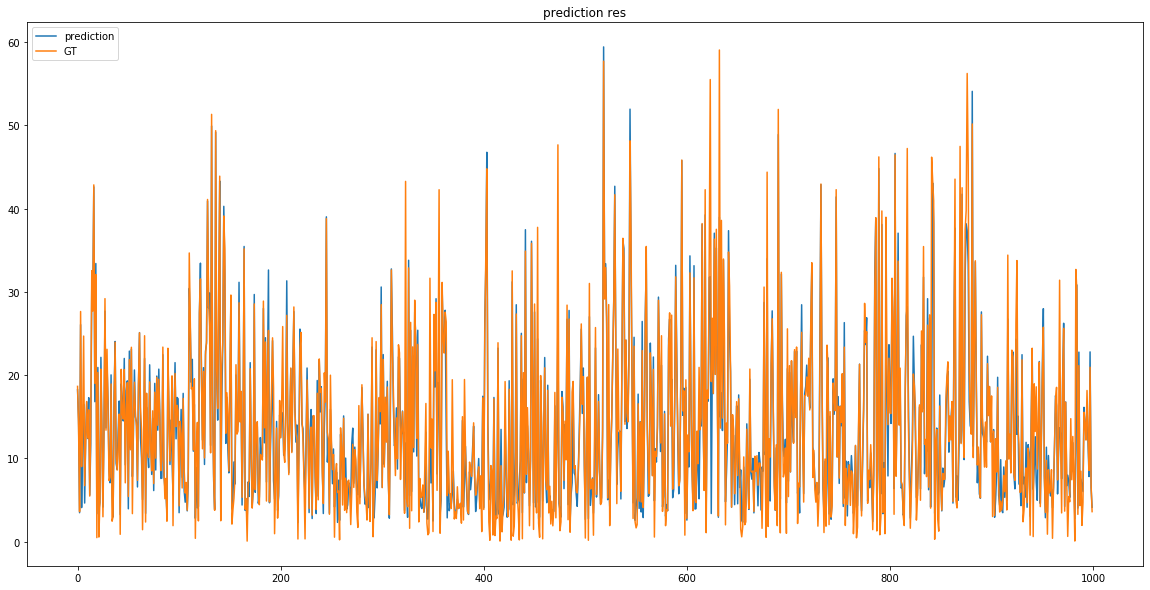

In [21]:
preds_test = model.predict(train_x, batch_size=32, verbose=1)
fig = plt.figure(figsize=(20, 10))
# plt.axes(facecolor='white')
plt.plot(preds_test)
plt.plot(train_y)
plt.title('prediction res')
plt.legend(['prediction', 'GT'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import r2_score

print(r2_score(train_y, preds_test[:,0]))
print('\n')
print(np.corrcoef(train_y, preds_test[:,0]))

In [ ]:
preds_test = model.predict(test_x, batch_size=32, verbose=1)

In [ ]:
for i in range(323):
#     print(float(preds_test[i]), '      ',float(test_y[i]))
#     print(float(preds_test[i]))
    print(float(test_y[i]))

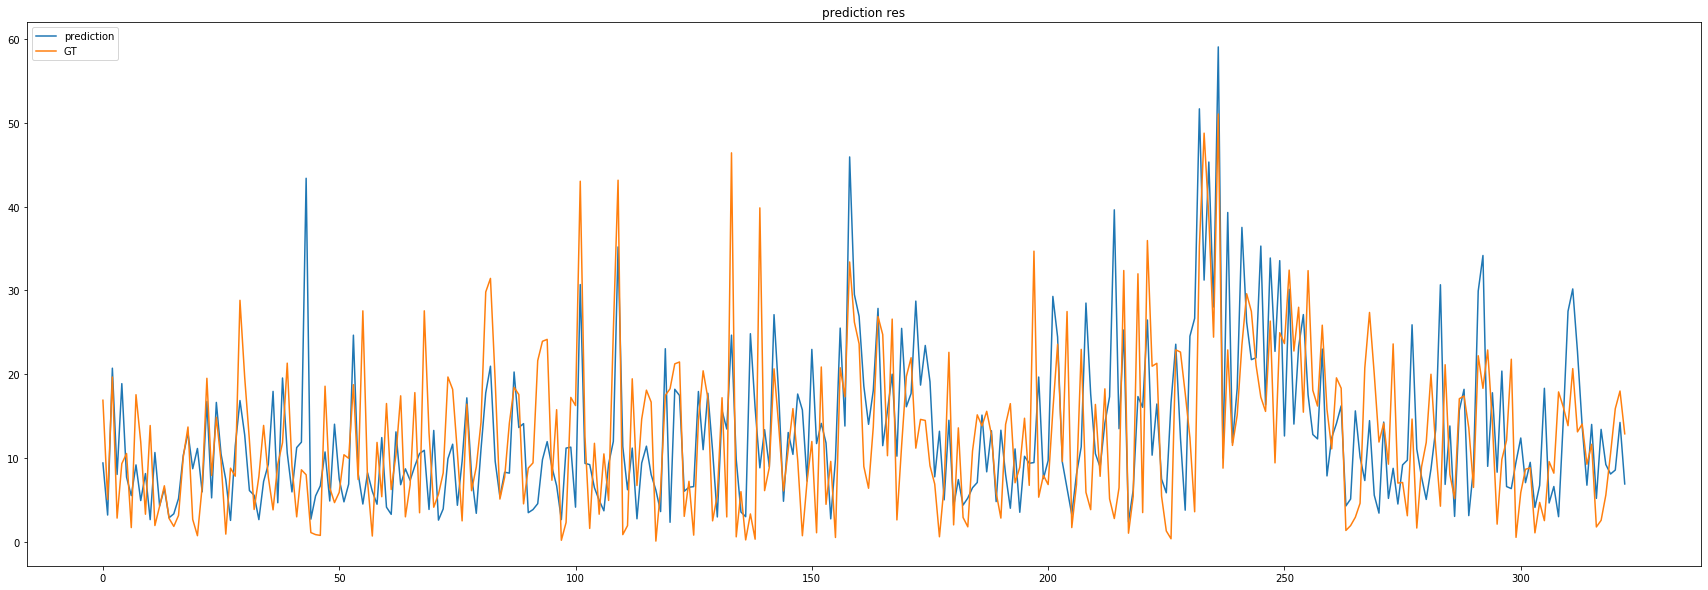

In [20]:
fig = plt.figure(figsize=(30, 10))
# plt.axes(facecolor='white')
plt.plot(preds_test)
plt.plot(test_y)
plt.title('prediction res')
plt.legend(['prediction', 'GT'], loc='upper left')
plt.show()

In [ ]:
# for i in range(10):
#     plt.imshow(test_x[i+25,:,:,0], cmap='gray')
#     plt.show()

In [ ]:
print(test_y.shape, preds_test.shape)

In [19]:
from sklearn import metrics

preds_test = model.predict(test_x, batch_size=32, verbose=1)
# calculate MAE, MSE, RMSE
print(metrics.mean_absolute_error(test_y, preds_test))
print(metrics.mean_squared_error(test_y, preds_test))
print(np.sqrt(metrics.mean_squared_error(test_y, preds_test)))

print('\n')
print(np.corrcoef(test_y, preds_test[:,0]))

323/323 [==============================] - 5s 15ms/step
6.9994287
82.631226
9.090172


[[1.         0.52415562]
 [0.52415562 1.        ]]


In [ ]:
plt.scatter(test_y, preds_test)
plt.xlabel(u"GT")
plt.ylabel(u"Preds")
plt.title("Corr")
plt.show()

In [ ]:
# model = load_model('/home/ubuntu/disk1/pancreas_segmentation/best_best.h5', custom_objects = {'tversky_loss': tversky_loss, 'generalized_dice_coeff': generalized_dice_coeff,'generalized_dice_coeff_loss1': generalized_dice_coeff_loss1})